# 🏦 Bank Customer Churn Prediction
## Notebook 3 — Data Cleaning

**Goal:** Produce a clean, analysis-ready DataFrame by:
1. Removing identifier columns (no predictive value).
2. Removing `Complain` (near-duplicate of the target → data leakage).
3. Documenting why we are NOT removing outliers in this dataset.
4. Saving the cleaned DataFrame as a checkpoint for N4.

> **What is data leakage?**  
> Leakage occurs when information from outside the valid training set leaks into the model.  
> `Complain` is only known *after* a customer has already churned — so using it would give the model "future" information it wouldn't have in a real deployment. The result: artificially high accuracy during training but **complete failure in production**.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')
# to run in your terminal, you may need to update the path of the dataset that is saved on your local machine

data = pd.read_csv('Customer-Churn-Records.csv')
print(f'Original shape: {data.shape}')
data.head()

Original shape: (10000, 18)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## 1. Confirm the `Complain` Data Leakage Problem

We documented this in EDA — let's formally quantify it here to justify the drop decision.

Pearson correlation  Exited ↔ Complain : 0.9957
% rows where Exited == Complain         : 99.9%

Breakdown (Exited , Complain):
Exited  Complain
0       0           7952
        1             10
1       0              4
        1           2034

Verdict: Complain is essentially the same information as the target.
         It MUST be dropped to prevent data leakage.


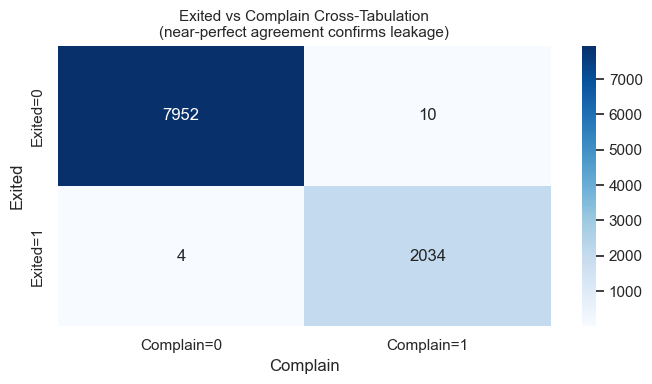

In [2]:
corr_EC = data['Exited'].corr(data['Complain'])
identical_pct = (data['Exited'] == data['Complain']).mean() * 100

print(f'Pearson correlation  Exited ↔ Complain : {corr_EC:.4f}')
print(f'% rows where Exited == Complain         : {identical_pct:.1f}%')
print()
print('Breakdown (Exited , Complain):')
print(data.groupby(['Exited', 'Complain']).size().rename('Count').to_string())
print()
print('Verdict: Complain is essentially the same information as the target.')
print('         It MUST be dropped to prevent data leakage.')

# Visualise the near-perfect overlap
fig, ax = plt.subplots(figsize=(7, 4))
ct = pd.crosstab(data['Exited'], data['Complain'])
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Complain=0', 'Complain=1'],
            yticklabels=['Exited=0', 'Exited=1'])
ax.set_title('Exited vs Complain Cross-Tabulation\n(near-perfect agreement confirms leakage)', fontsize=11)
plt.tight_layout()
plt.show()

## 2. Drop Columns

We drop four columns:

| Column | Reason |
|---|---|
| `RowNumber` | Sequential index — carries zero information |
| `CustomerId` | Unique ID — no generalizable pattern |
| `Surname` | Name — no generalizable pattern (and privacy concern) |
| `Complain` | Data leakage — near-duplicate of target |

The `axis=1` argument tells `drop()` to operate on columns (not rows).

In [3]:
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname', 'Complain']

df = data.drop(cols_to_drop, axis=1)

print(f'Shape before dropping : {data.shape}')
print(f'Shape after dropping  : {df.shape}')
print(f'Columns removed       : {cols_to_drop}')
print()
df.head()

Shape before dropping : (10000, 18)
Shape after dropping  : (10000, 14)
Columns removed       : ['RowNumber', 'CustomerId', 'Surname', 'Complain']



,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


## 3. Missing Values — Final Check

Although we confirmed no missing values in N2, it is good practice to re-verify after any column manipulation.

In [4]:
missing = df.isnull().sum()
total_missing = missing.sum()

if total_missing == 0:
    print('✅ No missing values detected. Dataset is complete.')
else:
    print('⚠️ Missing values found:')
    print(missing[missing > 0])

✅ No missing values detected. Dataset is complete.


## 4. Data Types — Final Check

We verify that all columns have the correct data type before passing the data to the feature engineering notebook.

In [5]:
print('Column data types after cleaning:')
print(df.dtypes)
print()
print('Expected types:')
print('  object  → Geography, Gender, Card Type  (text, will be encoded in N4)')
print('  int64   → HasCrCard, IsActiveMember, Exited, ...  (numeric / binary)')
print('  float64 → Balance, EstimatedSalary  (continuous)')

Column data types after cleaning:
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

Expected types:
  object  → Geography, Gender, Card Type  (text, will be encoded in N4)
  int64   → HasCrCard, IsActiveMember, Exited, ...  (numeric / binary)
  float64 → Balance, EstimatedSalary  (continuous)


## 5. Note on Outliers

A common step in data cleaning is **outlier removal**, but this dataset warrants no such action.  
Here is our reasoning:

- **`Balance = 0`** for ~36% of customers. This is a real and meaningful business state (customers who have no money in their account). Removing or imputing these values would distort the analysis.
- **`Age` range 18–92** — all plausible ages for bank customers.
- **`CreditScore` range 350–850** — valid credit score range.
- **`NumOfProducts` = 3 or 4** — unusual but valid; some customers hold many products.

**Rule of thumb:** Only remove outliers if they are *errors* (e.g., age = -5, salary = 999999999) or if they severely violate a model's assumptions. In tree-based models (our final choice), outliers have minimal impact because splits are based on rank, not magnitude.

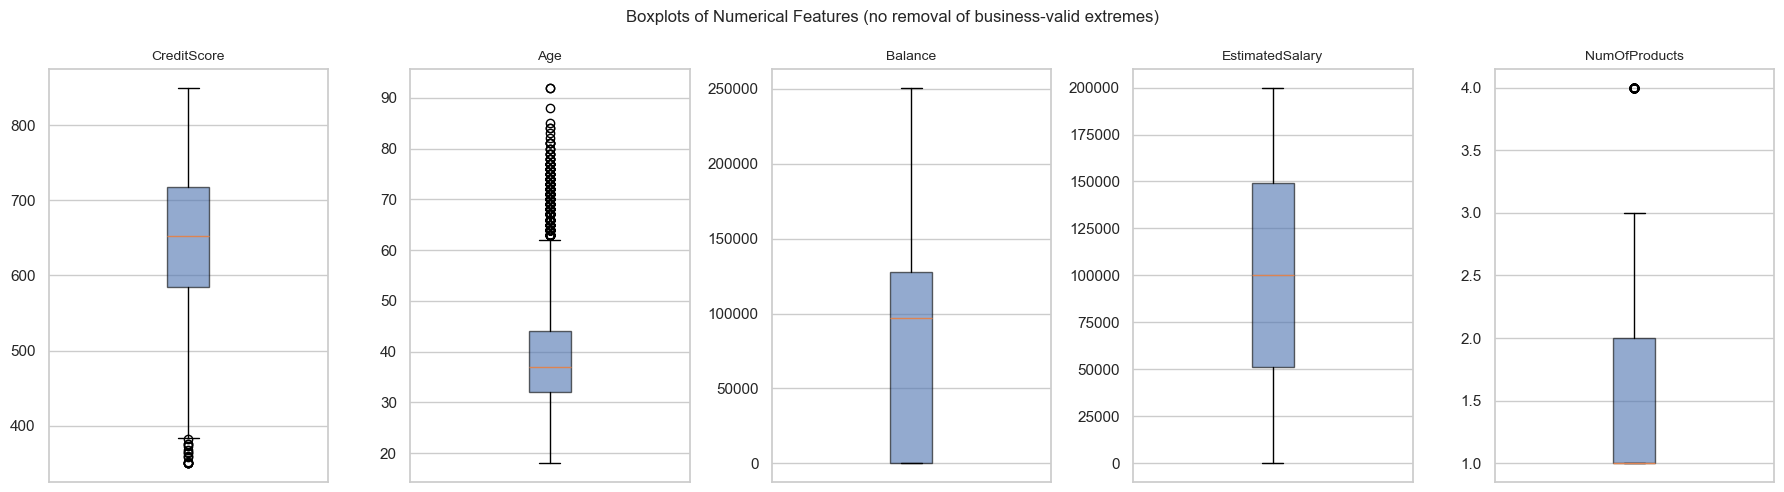

In [6]:
# Quick boxplots to visualise outlier extent
numerical_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'NumOfProducts']

fig, axes = plt.subplots(1, len(numerical_features), figsize=(18, 5))
for i, col in enumerate(numerical_features):
    axes[i].boxplot(df[col], patch_artist=True,
                    boxprops=dict(facecolor='#4C72B0', alpha=0.6))
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xticks([])

plt.suptitle('Boxplots of Numerical Features (no removal of business-valid extremes)', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Save Cleaned Data as Checkpoint

In [ ]:
# Save to CSV so N4 can start from the clean state without re-running earlier notebooks.
# index=False prevents pandas from adding an extra numeric index column.
# You can change the filename or path as needed. and chechk your folder after running to confirm it was created.

df.to_csv('df_cleaned.csv', index=False)

print(f'✅ Cleaned data saved to  df_cleaned.csv')
print(f'   Shape: {df.shape}  ({df.shape[0]:,} rows × {df.shape[1]} columns)')
print(f'   Remaining columns: {df.columns.tolist()}')

✅ Cleaned data saved to  df_cleaned.csv
   Shape: (10000, 14)  (10,000 rows × 14 columns)
   Remaining columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Satisfaction Score', 'Card Type', 'Point Earned']


---
## ✅ Cleaning Summary

| Step | Before | After |
|---|---|---|
| Columns | 18 | 14 |
| Rows | 10,000 | 10,000 |
| Missing values | 0 | 0 |
| Data leakage columns | 1 (`Complain`) | 0 |
| Identifier columns | 3 | 0 |

➡️ Continue to **N4_data_engineering** for feature scaling, encoding, and resampling.